# Sentiment Analysis on selected migration related articles over time (2015-2018)

* The goal of this analysis is to find out which was the evolution of the sentimental projection of the migration topic by the media, in this case, Der Spiegel.
* Due to the lack of labeled training datasets in german and, therefore, lack of robusst pre-trained sentiment models we will translate selected articles to english through the Google Translate API and apply existing models to the result.
* We want to use a recurrent neural network model (LSTM) since we want to consider the history on the sentiment over the words/sentences for each article (i.e. if there is a negation estatment it will be consider for all the sucessive words).
* In this case we will use a LSTM [model](https://github.com/openai/generating-reviews-discovering-sentiment) with 4,096 units we trained on the Amazon product review dataset introduced in McAuley et al. (2015) [1]. The dataset in de-duplicated form contains over 82 million product reviews from May 1996 to July 2014 amounting to over 38 billion training bytes. Training took one month across four NVIDIA Pascal GPUs, with our model processing 12,500 characters per second.
* The output of the model is the 4,096 hidden units from last layer. As reported in the paper for the binary version of the Stanford Sentiment Treebank (SST), the unit "2,388" contains the sentiment information (see distribution of values for positive and negative labels in the picture below). Therefore, we will just analyze the content of this one and apply over the results the binary classifier model as described [here](https://github.com/openai/generating-reviews-discovering-sentiment/blob/master/sst_binary_demo.py).
* In order to achieve our goal in considerable computational time (sentiment prediction of text with 642 words took half an hour in a 4 cores MacBook Air) and reduce the amount of request to Google API we will
    * Discard articles with more than 700 words
    * Select randomly 30 articles per quarter (calculated time in 4CPUs 15GB 1.8 days)
    * Discard n% initial and final sentences for each article

[1] McAuley, Julian, Pandey, Rahul, and Leskovec, Jure. Inferring networks of substitutable and complementary products. In Proceedings of the 21th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, pp. 785–794. ACM, 2015

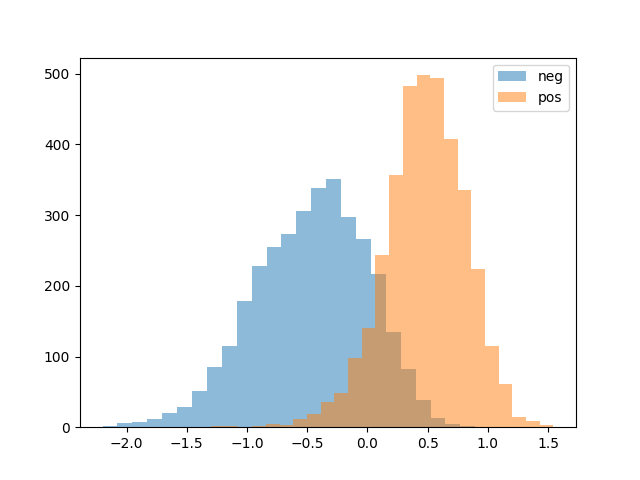

In [127]:
from IPython.display import Image
Image("../../img/sst_binary_sentiment_unit_vis.png")

We can expect that only texts with a sentiment score out of the range [-1,1] could be labeled as negative or positive respectively. Otherwise, the general sentiment should have the neutral label.

In [1]:
import nltk
import re
import sys
import os
import pickle
import requests
import datetime
import argparse
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('subjectivity')
from nltk.sentiment.util import demo_vader_instance, demo_sent_subjectivity
sys.path.append("../..")
from src.helpers import google_translator, assign_quarter_labels, get_quarter_boundaries
sys.path.append("../../../generating-reviews-discovering-sentiment/")
from encoder import Model
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/celsadiaz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package subjectivity to
[nltk_data]     /Users/celsadiaz/nltk_data...
[nltk_data]   Package subjectivity is already up-to-date!


/Users/celsadiaz/.pyenv/versions/3.6.2/envs/nlp/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
/Users/celsadiaz/.pyenv/versions/3.6.2/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Use the German stopwords.
stpwrds = stopwords.words("german")

# We added some additional characters to avoid.
characters = [',', '.', '(', ')', '!', ';', '-', ':', '...', '"',
                "''", "``", '~http', '?', '@', '#', '/', "'",
                '&', '--', '[', ']', '=', '||', '+', '_', '..',
                '%', '|', '~', 'http',"\n","—","•","“","„","–",
                "في","שראל","россии","не","минобороны","и","в",
                "את", "$",">","*"]

# Selection of articles parameters
# number of top articles with higher frequencies on key words for selecting the final ones
n_pre_selected = 75
n_articles = 30
language = 'en'

In [12]:
# Load selected articles about migration
articles = pd.read_csv("../../data/migration_articles.csv")
articles.date = articles['date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))

In [13]:
articles[(articles['date'].dt.year == 2015) & (articles['quarter'] == 'q11_18')]

,text,date,meta_description,time_line,quarter,is_summary,text_length,article_id,freq


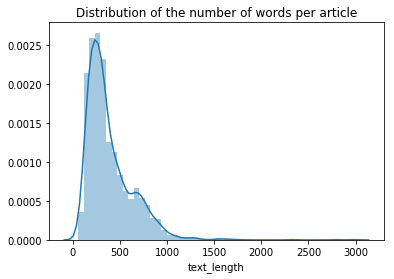

In [5]:
# Explore the distribution of number of words per article
articles['text_length'] = articles['text'].apply(lambda x: len(x.split(" ")))
_=sns.distplot(articles['text_length'])
_=plt.title("Distribution of the number of words per article")

It looks like there are two main types of articles, short ones of around 300 words and longer ones of around 700. We will get focused on the short ones in the sentiment analysis for performance reasons fixing the length threshold at 700 words.

In [6]:
articles_short = articles[articles["text_length"] < 700].reset_index(drop=True)

In [7]:
articles_short.head()

,text,date,meta_description,time_line,quarter,is_summary,text_length,article_id,freq
0,Die Offensive von Baschar al-Assad im Süden Sy...,2018-07-09,Syrien plant einen Angriff auf die Golanhöhen....,32080,q11_18,0,559,32080,0.011696
1,In der Debatte um die Asylpolitik in Deutschla...,2018-07-09,Entwicklungshilfeminister Gerd Müller (CSU) ha...,32071,q11_18,0,249,32071,0.012903
2,Wenige Tage vor dem EU-Ministertreffen in Inns...,2018-07-08,Italien weist bereits Schiffe von Hilfsorganis...,32062,q11_18,0,314,32062,0.018779
3,Der Vorwurf wiegt schwer: Niedersachsens Innen...,2018-07-08,Niedersachsens Innenminister Pistorius soll ei...,32056,q11_18,0,265,32056,0.013072
4,"Liebe Abonnentin, lieber Abonnent,\n\nin unser...",2018-07-07,Deutschlands führende Nachrichtenseite. Alles ...,32033,q11_18,0,513,32033,0.010033


In [64]:
print(f"There are {len(articles_short)} articles about migration with less than 700 words.")

There are 2388 articles about migration with less than 700 words.


### Select a set of 30 articles per quarter

In [119]:
def extract_n_articles_and_translate(data, n_pre_selected, n_articles, language):
    articles_selected = []
    for i, df in data.groupby(["quarter"]):
        # Select 30 articles from the top 75 with highest frequency on key words to ensure
        # that they target mainly the migration topic
        df_sort = df.sort_values(by="freq", ascending=False).reset_index(drop=True)
        df_sort = df_sort.loc[:n_pre_selected]
        articles_id = df_sort.article_id.tolist()
    
        # fix seed to have reproducible results and extract the selected articles
        np.random.seed(0)
        np.random.shuffle(articles_id)
        df_sort_sel = df_sort[df_sort["article_id"].isin(articles_id[:n_articles])]
        articles_selected.append(df_sort_sel)

    # check a couple of examples
    articles_selected_ = pd.concat(articles_selected).reset_index(drop=True)
    print(f"The selection of articles looks like this {articles_selected_.loc[:5].meta_description.tolist()}")

    # translate selected articles
    articles_selected_["text_en"] = articles_selected_["text"].apply(lambda x: google_translator(x, language))
    return articles_selected_

In [120]:
#articles_selected_ = extract_n_articles_and_translate(articles_short, n_pre_selected, n_articles, language)

In [71]:
# Goole translate API can not translate all the artcles at once and therefore we need to run it several times
if len(articles_selected_[articles_selected_["text_en"].isnull()]) > 0:
    # translate articles that for some reason were not translated
    non_translated = articles_selected_[articles_selected_["text_en"].isnull()]
    non_translated["text_en"] = non_translated["text"].apply(lambda x: google_translator(x, language))
    
    translated = non_translated[non_translated['text_en'] != '']
    
    # update translations
    articles_to_replace = translated.index.tolist()
    for art in articles_to_replace:
        articles_selected_.loc[art, "text_en"] =  translated.loc[art, "text_en"]

In [72]:
# ensure that all texts are translated
articles_selected_[articles_selected_["text_en"].isnull()]

,text,date,meta_description,time_line,quarter,is_summary,text_length,article_id,freq,text_en


In [90]:
articles_selected_.to_csv("../../data/330_selected_art_translated.csv", index=False, encoding='utf-8')

#### Extract articles IDs of the analyzed articles to match sentiment to date

In [10]:
articles_selected = pd.read_csv("../../data/330_selected_art_translated.csv")
articles_selected.date = articles_selected['date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))

In [16]:
articles_sel_correct = articles_selected.loc[:,('date','quarter',
                         'time_line')].rename(columns={'quarter':'wrong_q'}).merge(articles.loc[:,('date',
                                         'quarter','time_line')],
                                            left_on='time_line', right_on='time_line')

In [34]:
articles_sel_correct[(articles_sel_correct['date_x'].dt.year == 2015) & (articles_sel_correct['quarter'] == 'q11_18')]

,date_x,wrong_q,time_line,date_y,quarter


In [20]:
order_articles_asc = articles_sel_correct.sort_values(by='date_x').index.tolist()

In [22]:
se_order_art_to_quarter = articles_sel_correct.sort_values(by='date_x').quarter

In [23]:
len(se_order_art_to_quarter)

330

### Run sentiment analysis of selected articles in Google Cloud

#### Test performance with first article

Performance
- macbook air: 4cores 4GB 
    - article with 319 words/2368 characters 1274.9s -> 21.2’
    - total = 30 articles/quarter x 11 quarters x 21.2' -> 4.8 days
- GC: 4CPUs 15GB
    - article with 319/2368 characters 479.9 -> 7.9’
    - total = 30 articles/quarter x 11 quarters x 7.9' -> 1.8 days

### Check sentiment

In [24]:
file_100 = open("../../data/sentiment_analysis_scores_checkpoint.pkl",'rb')
file_100_on = open("../../data/sentiment_analysis_scores.pkl",'rb')
sentiment_100 = pickle.load(file_100)
sentiment_100_on = pickle.load(file_100_on)

In [25]:
sentiment = sentiment_100[:100] + sentiment_100_on

In [26]:
len(sentiment)

330

###### Sentiment per article evolution

In [27]:
# shape results array with sentiment per article to be readable
sentiment_clean = pd.DataFrame(sentiment).T.dropna().T
rec = [{'a_idx': ia, 'sentiment': sent} for ia, a in enumerate(sentiment)  for sent in a]
df = pd.DataFrame.from_records(rec)

# order articles by date (2015 -> 2018)
tmp_ordered = []
for i, art in enumerate(order_articles_asc):
    sel = df[df['a_idx']==art]
    sel['index'] = i
    tmp_ordered.append(sel)
tmp_ordered = pd.concat(tmp_ordered).reset_index(drop=True)

In [45]:
len(tmp_ordered)#.quarter.tolist()

675008

In [46]:
tmp_ordered.head()

,a_idx,sentiment,index,quarter
0,63,0.066523,0,q1_15
1,63,0.085444,0,q1_15
2,63,0.059376,0,q1_15
3,63,0.051347,0,q1_15
4,63,-0.001240,0,q1_15


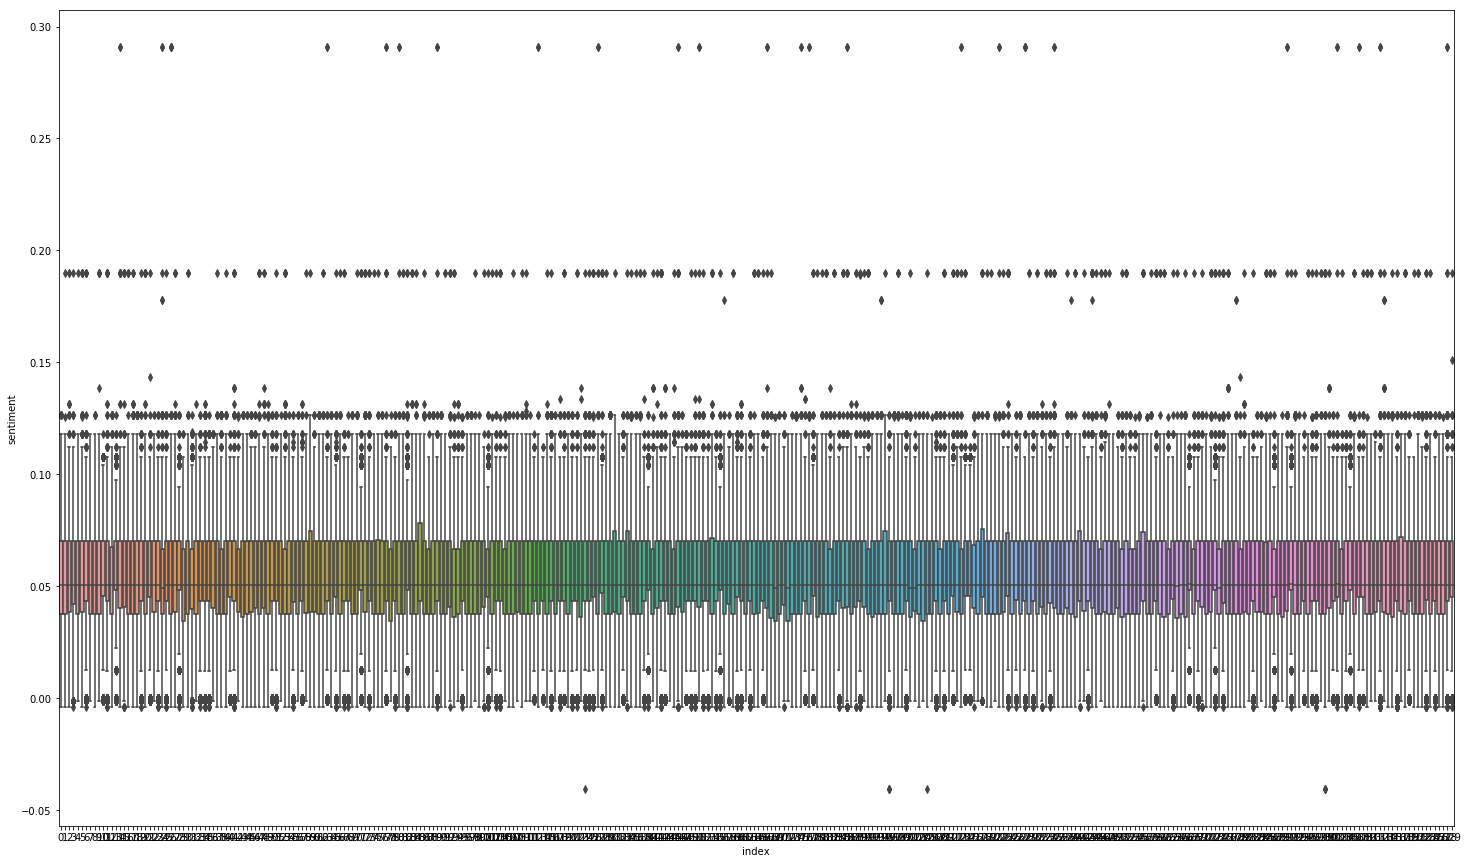

In [29]:
plt.figure(figsize=(25, 15))
sns.boxplot(data=tmp_ordered, x='index', y='sentiment')

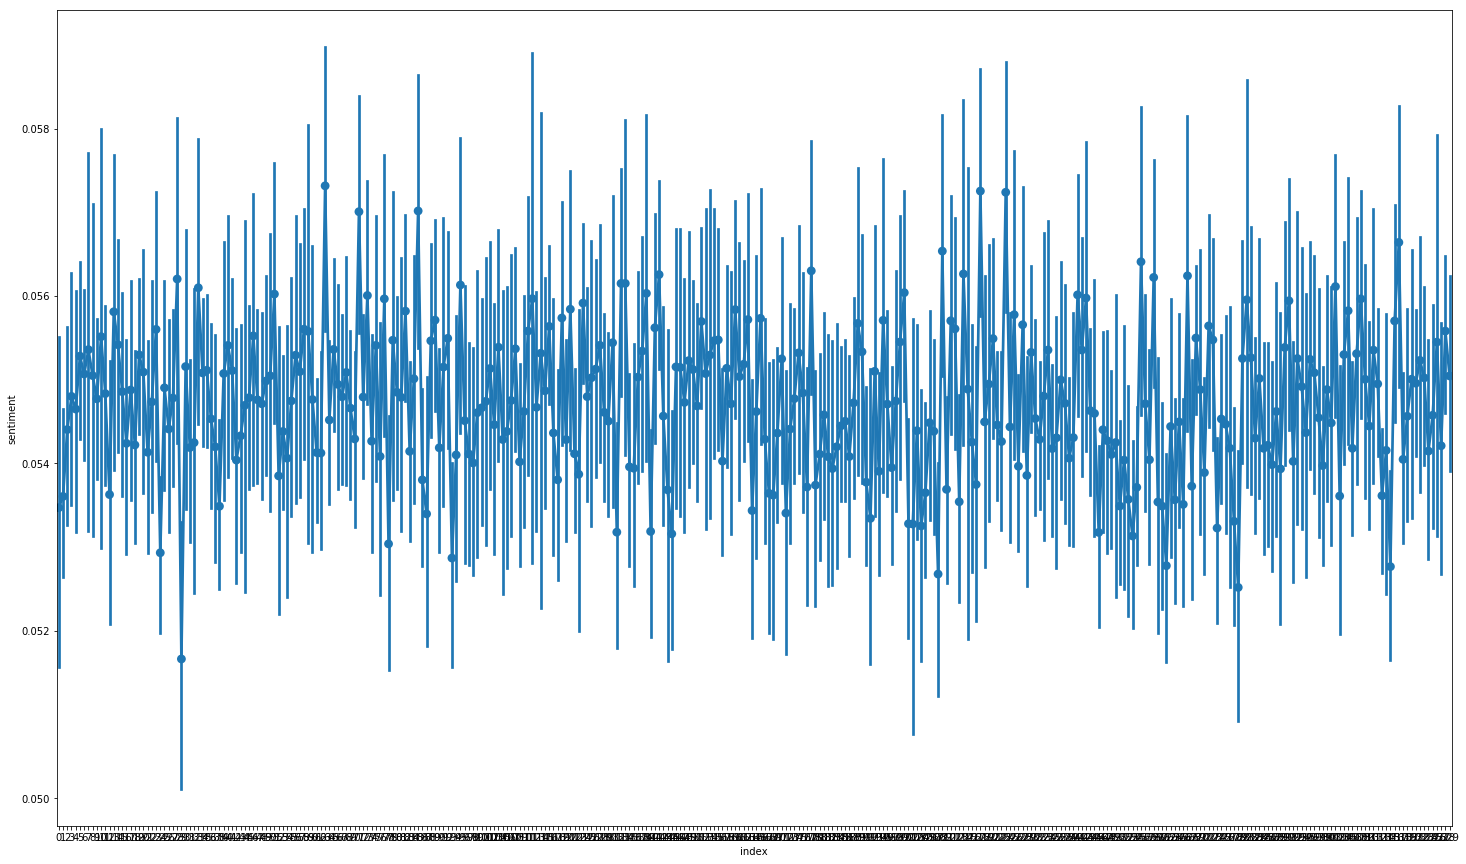

In [30]:
plt.figure(figsize=(25, 15))
sns.pointplot(data=tmp_ordered, x='index', y='sentiment')

###### Sentiment per quarter

In [31]:
# map quarters to idx_a
tmp_ordered['quarter'] = tmp_ordered['a_idx'].map(se_order_art_to_quarter)

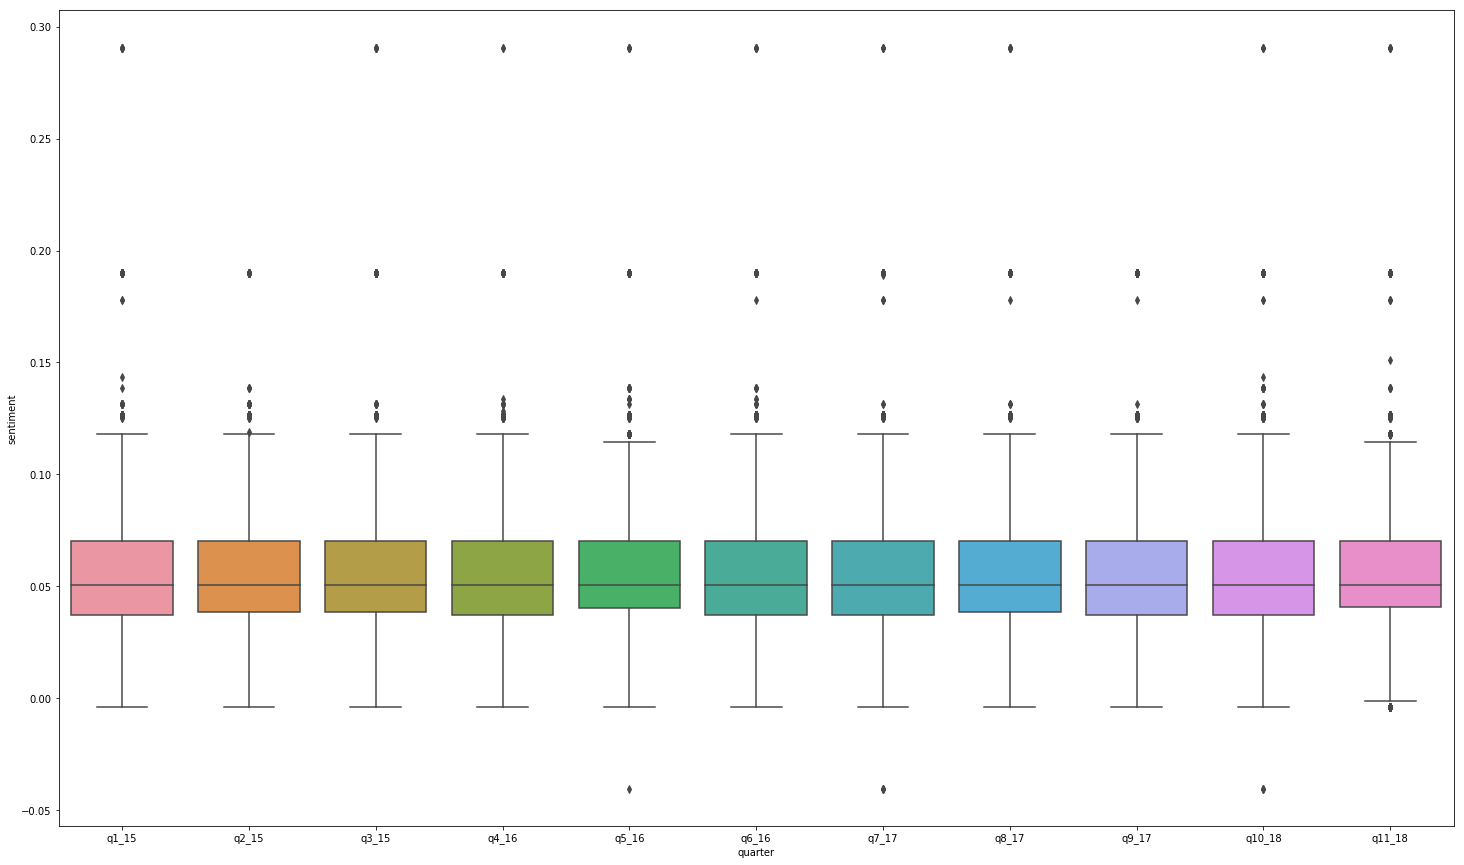

In [32]:
plt.figure(figsize=(25, 15))
sns.boxplot(data=tmp_ordered, x='quarter', y='sentiment')

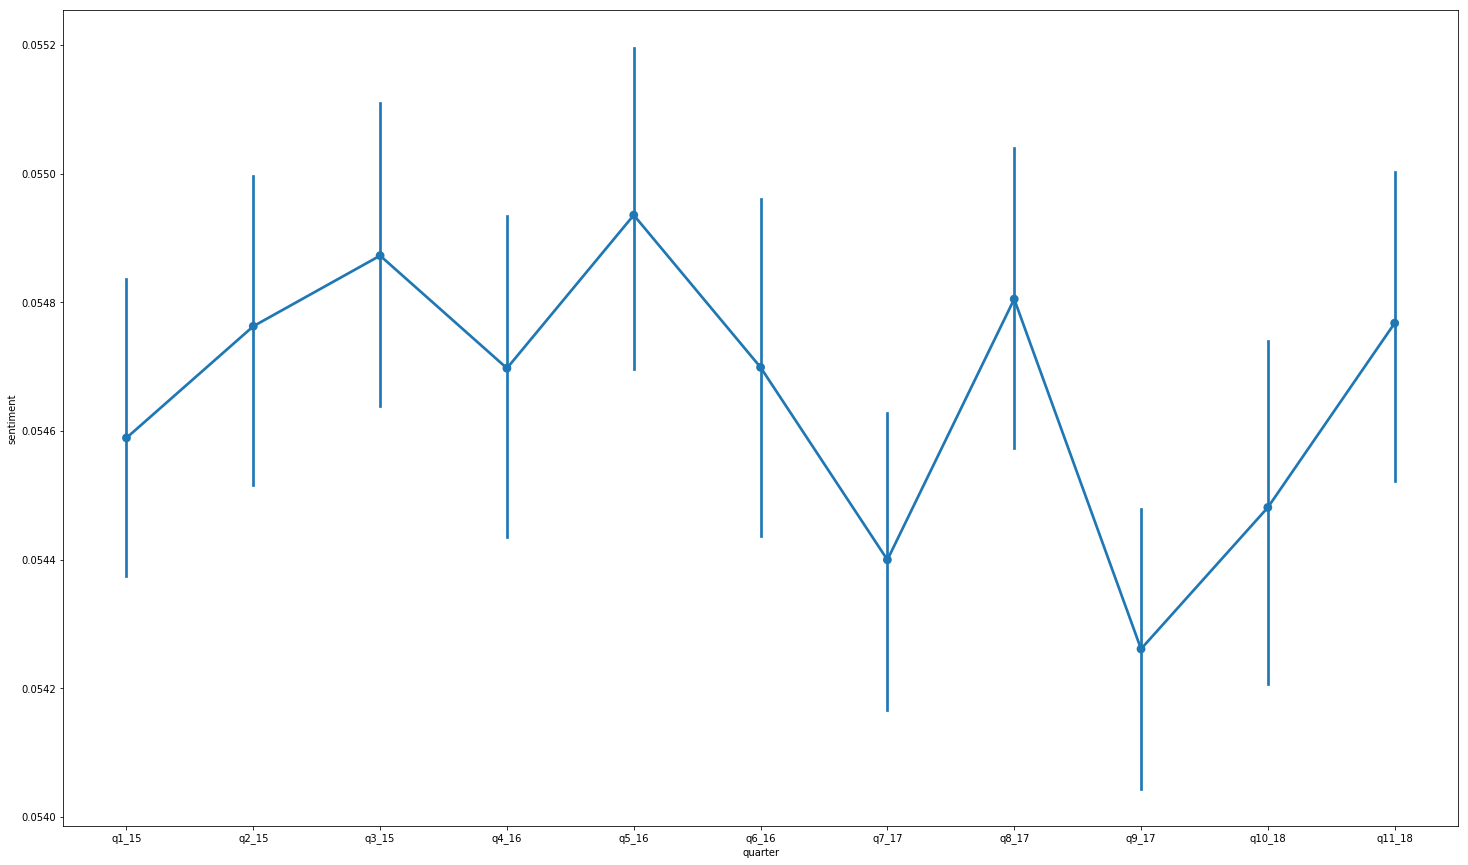

In [33]:
plt.figure(figsize=(25, 15))
sns.pointplot(data=tmp_ordered, x='quarter', y='sentiment')

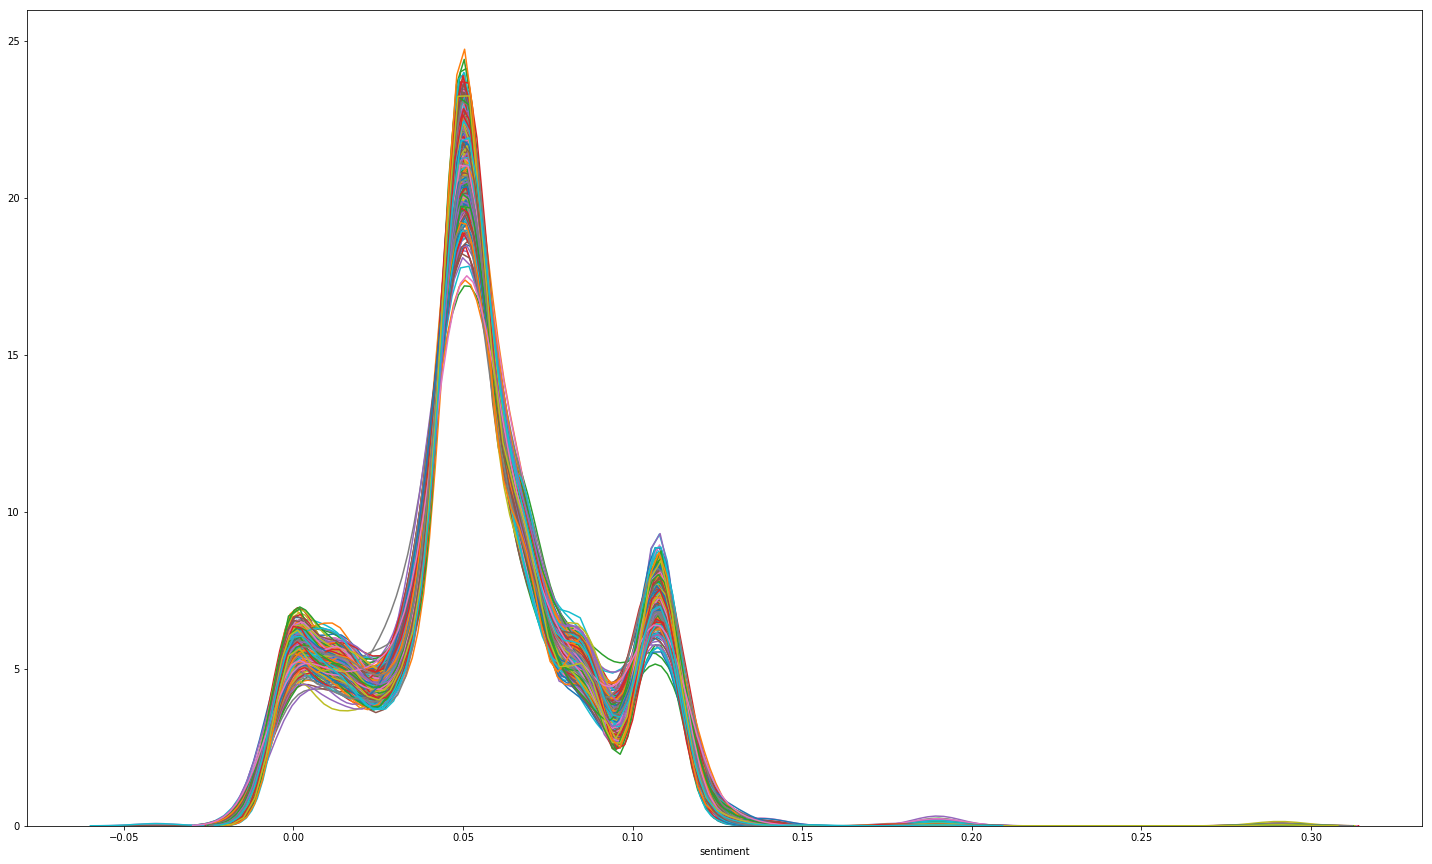

In [44]:
plt.figure(figsize=(25, 15))
for i in tmp_ordered.a_idx.unique().tolist():#[::5]:
    sns.distplot(tmp_ordered[tmp_ordered['a_idx']==i]['sentiment'], hist=False, rug=False)

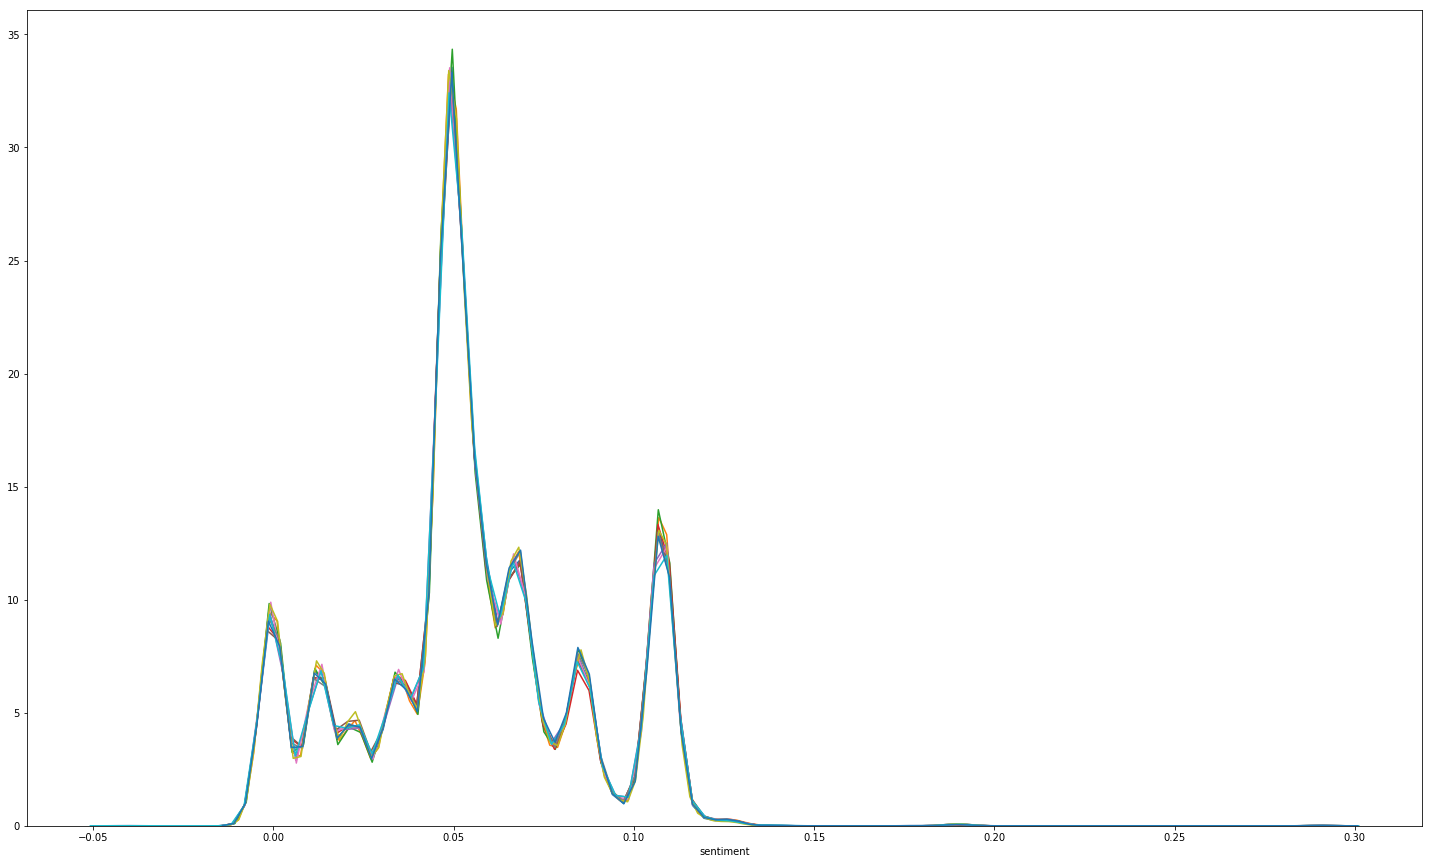

In [36]:
plt.figure(figsize=(25, 15))
for i in tmp_ordered.quarter.unique().tolist():
    sns.distplot(tmp_ordered[tmp_ordered['quarter']==i]['sentiment'], hist=False, rug=False)